# ANL Cluster Lensing Simulations w/ DC2 area overlap
Authors: **Joe Hollowed**

In this example script, I show how to access a preliminary set of simulated cluster-scale halos from the Outer Rim particle lightcone (the substrate of cosmoDC2). Each object in this dataset is the result of ray-tracing through a narrow slice of the octant, centered on a massive halo. Each lightcone shell is treated as a lens plane (80-100Mpc/h wide, ~50 planes per halo LOS), and we have full particle information (_mpp_~1e9 M<sub>sun</sub>h<sup>-1</sup>) for the entire line of sight, extending to _z_~2-2.5, depending on the target halo. 

The lens planes are constructed relative to a source redshift of z=10, and ray tracing is (for now) performed from a single source plane, the depth of which is given in the data. We will be using `h5py` to read in the ray-tracing's hdf5 outputs (located in `./data`).

Data contents:

- `halo_xxxxxx_x` (per-halo directory containing unique lightcone identifier xxxxxx_x)

    &rarr; `halo_xxxxxx_x_zs0_gmaps.hdf5` - hdf5 file containing 1024x1024 lensing grid maps (matrices) per lens plane, calculated from a reference source redshift of z=10.
    
    &rarr; `halo_xxxxxx_x_zs_raytraced_maps.hdf5` - hdf5 file containing 1024x1024 ray-traced grid maps at the source plane `zs`.
    
    &rarr; `dtfe_dens` - per-lens plane result (and tiff images) of the the DTFE
    
    &rarr; `xj` - internal quantities 

    &rarr; `properties.csv` - FOF, SOD, and lightcone halo properties (look here to find which lens plane contains the target halo, its true mass and radius, etc...) 

__Hack Suggestions__:

- First-order beta test of these outputs; shear profiles, etc.
- Strategize on useful output form/content for analysis going forward
- Extend CLMM to read in this stuff
- Obtain high resolution lensing quantities at cosmoDC2 galaxy positons (match on central galaxy host ID to lens halo ID) 

##### __Logistics__: This notebook is intended to be run through the JupyterHub NERSC interface available here: https://jupyter-dev.nersc.gov. To setup your NERSC environment, please follow the instructions available here: https://confluence.slac.stanford.edu/display/LSSTDESC/Using+Jupyter-dev+at+NERSC. 

##### These data products were produced with:

##### - The Outer Rim HACC Simulation (https://arxiv.org/abs/1410.2805)

##### - Lightcone generation code and subsequesnt cluster LOS extraction (https://www.joehollowed.com/assets/docs/HACCLightcones_v2.0.pdf; https://github.com/jhollowed/cosmo-cutout)

##### - Parallel DTFE Surface Density Field Reconstruction by Steve Rangel (https://github.com/steverangel/SDTFE; http://cucis.ece.northwestern.edu/publications/pdf/RLH16.pdf)

##### - Ray tracing modules by Nan Li (https://arxiv.org/abs/1511.03673)

In [1]:
# first equip our weapons
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
def step2z(step): return np.linspace(1/(200_1), 1, 500)[step]
def safeLog10(x, minval=1e-7): return np.log(x.clip(min=minval))

# point to the data
data_path = '/global/homes/h/hollowed/desc_CLxCS_2019/data'

The grid maps are written with each hdf5 group representing one lens plane. In the various X.gmaps.hdf5 files, there will be one group per lens plane, corresponding to the redshift bounds of a shell of the base particle lightcone, and named after the corresponding HACC simulation timestep. If you need to convert those timestep values to redshift, call the `step2z()` lambda function provided above

In [4]:
# randomly choose one of the 9 halos provided in the preliminary dataset to read
# (change idx if you want something constant, this is just for convenience)

#halos_available = np.array([s.split('/')[-1] for s in glob.glob('./data/*')])
halos_available = np.array([s.split('/')[-1] for s in glob.glob(data_path+'/*')])
idx = int(np.random.rand(1)*len(halos_available))
halo_id = halos_available[idx]
print('\n---- Working on halo {} ----'.format(halo_id))

prop_file = '{0}/{1}/properties.csv'.format(data_path, halo_id)
gmaps_file = '{0}/{1}/{1}_10.0_gmaps.hdf5'.format(data_path, halo_id)
raytrace_file = glob.glob('{0}/{1}/{1}_*_raytraced_maps.hdf5'.format(data_path, halo_id))[0]
halo_properties = np.genfromtxt(prop_file, delimiter=',')
print('---- Located at redshift z = {} ----'.format(halo_properties[0]))



---- Working on halo halo_4774009586007965696_0 ----
---- Located at redshift z = 0.324669 ----


In [5]:
# read the ray traced file for the source redshift

halo_raytrace = h5py.File(raytrace_file, 'r')
source_z = list(halo_raytrace.keys())[0] 
print('source plane at z = ',list(halo_raytrace.keys()))
g1 = halo_raytrace[source_z]['shear1'].value
g2 = halo_raytrace[source_z]['shear2'].value
kf0 = halo_raytrace[source_z]['kappa0'].value
logk = safeLog10(kf0.T)

source plane at z =  ['zs_1.4488']


In [6]:
print(min(g1.flatten()),max(g1.flatten()))

-0.0952084 0.0401341


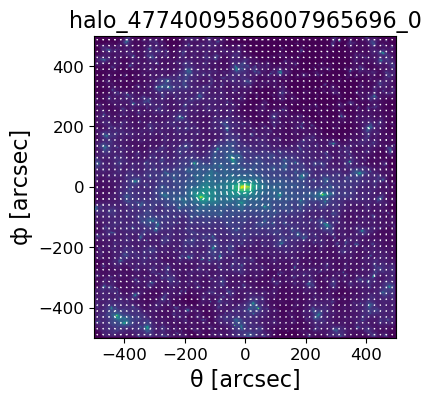

In [7]:
# visualize the convergence and shear...

# get scale of FOV and define grid
nnx, nny = np.shape(logk)
boxsize_arcsec = float(halo_properties[8])
ds = boxsize_arcsec/nnx
x1 = np.linspace(0,boxsize_arcsec-ds,nnx)-boxsize_arcsec/2.0+ds/2.0
x2 = np.linspace(0,boxsize_arcsec-ds,nnx)-boxsize_arcsec/2.0+ds/2.0
x2,x1 = np.meshgrid(x1,x2)

# define figure, plot convergence on color axis
plt.figure(figsize=(4, 4), dpi=100)
plt.imshow(logk,aspect='equal',cmap=plt.cm.viridis,origin='higher',
           extent=[-boxsize_arcsec/2.0,
                    boxsize_arcsec/2.0,
                   -boxsize_arcsec/2.0,
                    boxsize_arcsec/2.0,], 
                    vmin=np.percentile(logk, 5))

# plot shear vector field
grid_spacing = 20
scale_shear = 180

for i in range(int(grid_spacing/2),nnx,grid_spacing):
    for j in range(int(grid_spacing/2),nny,grid_spacing):
        gt1 = g1[i, j]
        gt2 = g2[i, j]
        ampli = np.sqrt(gt1*gt1+gt2*gt2)
        alph = np.arctan2(gt2,gt1)/2.0

        st_x = x1[i, j]-ampli*np.cos(alph)*scale_shear
        ed_x = x1[i, j]+ampli*np.cos(alph)*scale_shear

        st_y = x2[i, j]-ampli*np.sin(alph)*scale_shear
        ed_y = x2[i, j]+ampli*np.sin(alph)*scale_shear

        plt.plot([st_x,ed_x],[st_y,ed_y],'w-',linewidth=1.0)

plt.xlim(-boxsize_arcsec/2.0, boxsize_arcsec/2.0)
plt.ylim(-boxsize_arcsec/2.0, boxsize_arcsec/2.0)
plt.xlabel('θ [arcsec]', fontsize=16)
plt.ylabel('ф [arcsec]', fontsize=16)
plt.gca().tick_params(axis='both', which='major', labelsize=12)
plt.title(halo_id, fontsize=16)

plt.show()

Okay, this should get you started! If there are any questions/ideas/suggestions, let's chat. 

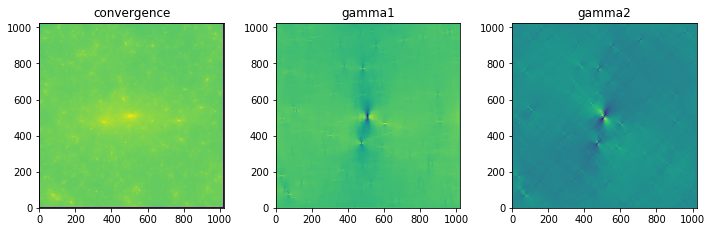

In [8]:
f, axes = plt.subplots(1, 3, figsize=(10,10))
axes[0].pcolormesh(logk)
axes[0].set_title('convergence')
axes[1].pcolormesh(g1)
axes[1].set_title('gamma1')
axes[2].pcolormesh(g2)
axes[2].set_title('gamma2')
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')
f.tight_layout()

# Populating shear maps with galaxies

In [9]:
# ~~~ Setting parameters

nperarcmin = 500 # galaxies per arcmin

ra_0, dec_0 = 0,0 # in arcsec

side_length = halo_properties[8] # in arcsec
print(side_length)
redshift = float(list(halo_raytrace.keys())[0][3:])

999.999


In [10]:
# ~~~ Choosing random pixels to serve as galaxies

area = (side_length/60.)**2 # in arcmin**2

threshold = nperarcmin*area/(len(g1)**2)

mask = np.random.rand(*g1.shape)<threshold

print(np.sum(mask))

139063


### things we need: ra, dec, gamma1, gamma2

In [11]:
pos = ((np.argwhere(mask) - [g1.shape[0]/2,g1.shape[0]/2])*side_length/len(g1) + \
       [ra_0,dec_0])/3600

In [12]:
ra,dec=list(zip(*pos))

In [13]:
print(min(ra), max(ra))
print(min(dec), max(dec))


-0.13888875 0.13861748291
-0.13888875 0.13861748291


In [14]:
np.sum(g1!=0)

1028196

139063

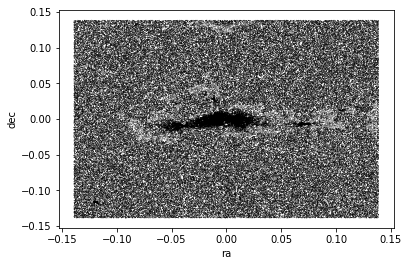

In [15]:
# selected galaxy locations
# plt.plot
# plt.plot(ra,dec,'.')
plt.quiver(ra,dec, g1[mask]/5, g2[mask]/5)

# for i,j in np.argwhere(mask):
#     gt1 = g1[i, j]
#     gt2 = g2[i, j]
    
#     plt.quiver(ra)
#     ampli = np.sqrt(gt1*gt1+gt2*gt2)
#     alph = np.arctan2(gt2,gt1)/2.0

#     st_x = x1[i, j]-ampli*np.cos(alph)*scale_shear
#     ed_x = x1[i, j]+ampli*np.cos(alph)*scale_shear

#     st_y = x2[i, j]-ampli*np.sin(alph)*scale_shear
#     ed_y = x2[i, j]+ampli*np.sin(alph)*scale_shear

#     plt.plot([st_x,ed_x],[st_y,ed_y],'w-',linewidth=1.0)

plt.xlabel('ra')
plt.ylabel('dec')

np.sum(mask)

In [16]:
redshift

1.4488

In [17]:
### Now import this information for CLMM

In [18]:
from clmm import datatypes
from clmm import ShearAzimuthalAverager
from astropy.table import Table


In [19]:
# cluster dictionary
cl_dict = {'z':halo_properties[0], 'ra':0., 'dec': 0.}

In [25]:
# source table
# We need a -g2 as the convention on the ANL maps is not the same as in CLMM
t = Table([np.arange(len(ra)),ra, dec, g1[mask],-g2[mask],\
           [redshift]*len(ra),kf0[mask]],\
           names=('id','ra','dec', 'gamma1', 'gamma2', 'z', 'kappa'))

In [21]:
t_clmm = datatypes.GCData('source catalog', {}, t)
t_clmm

GCData(creator='source catalog', specs={}, values=<Table length=139063>
  id         ra            dec        gamma1  gamma2    z     kappa 
int64     float64        float64     float32 float32 float64 float32
------ ------------- --------------- ------- ------- ------- -------
     0   -0.13888875 -0.137261147461     0.0    -0.0  1.4488     0.0
     1   -0.13888875 -0.136447346191     0.0    -0.0  1.4488     0.0
     2   -0.13888875 -0.131835805664     0.0    -0.0  1.4488     0.0
     3   -0.13888875 -0.131022004395     0.0    -0.0  1.4488     0.0
     4   -0.13888875 -0.129936936035     0.0    -0.0  1.4488     0.0
     5   -0.13888875 -0.126952998047     0.0    -0.0  1.4488     0.0
     6   -0.13888875 -0.125867929688     0.0    -0.0  1.4488     0.0
     7   -0.13888875 -0.124782861328     0.0    -0.0  1.4488     0.0
     8   -0.13888875 -0.123155258789     0.0    -0.0  1.4488     0.0
     9   -0.13888875  -0.12207019043     0.0    -0.0  1.4488     0.0
   ...           ...           

In [22]:
saa = ShearAzimuthalAverager(cl_dict, t_clmm)

/global/common/cori/software/python/3.6-anaconda-5.2/lib/python3.6/site-packages/astropy/table/row.py:65: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


read g1, g2 directly


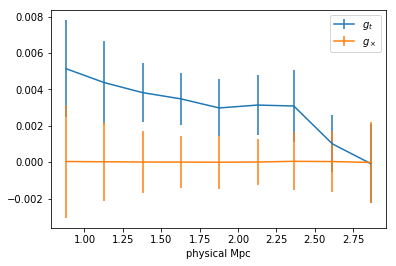

In [24]:
# compute tangential and cross shear for each galaxy
saa.compute_shear()

# make the binned profile
binned_profile = saa.make_shear_profile()

saa.plot_profile()   